# Derivatives of a functions using Finite Differences - Differenzenquotient
In the lecture, we learned different ways to calculate the derivative of a function:
- finite differences
    - forward difference
    - central difference
- automatic differentiation (AD)
    - forward mode (future exercise)
    - reverse mode (future exercise)

> Note: A good explanation for the error in estimating derivatives and automatic differentiation can be found here: https://book.sciml.ai/notes/08-Forward-Mode_Automatic_Differentiation_(AD)_via_High_Dimensional_Algebras/ 
> Some parts of this exercise are based on these lecture notes.

The derivative of a function $f(x)$ can be approximated by the finite differences:
$$
\frac{d f}{d x} \approx \frac{f(x + \Delta x) - f(x)}{\Delta x}
$$
This is called the forward difference. We can also use the central difference:
$$
\frac{d f}{d x} \approx \frac{f(x + \Delta x) - f(x - \Delta x)}{2 \Delta x}
$$

In the lecture we already discussed that the step size $\Delta x$ has a big influence on the error of the approximation. We want to investigate this influence and visualize the error for different step sizes $\Delta x$. What is the smallest number we can use for $\Delta x$? What happens if we use such a small number? What happens if we use a larger number? 

In [ ]:
import Pkg
Pkg.activate("../Exercise 4/OpenMEnv")
Pkg.add("Revise")
Pkg.add("LinearAlgebra")
Pkg.add("FiniteDifferences")
Pkg.add("Plots")
Pkg.add("Printf")

In [1]:
import Pkg
Pkg.activate("../Exercise 4/OpenMEnv")
using FiniteDifferences
using Printf
using Plots

  Activating project at `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/IngGru_numerik/SS2024/Excercise/Exercise 4/OpenMEnv`


At first let's take a look at the forward and central finite difference methods. We let's start by defining a function we want to differentiate together with the differentiation so that we can estimate the error we are making.

In [2]:
# defining a function and its derivative
function f(x)
    x^2 + sin(x)
end

function df(x)
    2 * x + cos(x)
end

df (generic function with 1 method)

Now let's define the point `x` at which we want to evaluate the derivative. An compare the forward finite difference method with the central finite difference method.

In [3]:
# Point where we want to approximate the derivative
x = 2.0

# testing the finite difference methods for the function f(x) = x^2+sin(x)
central_fdm(2, 1)(f, x) # 2 is the number of points and 1 is the order of the derivative
forward_fdm(2, 1)(f, x)
df(2)
error_cforward = abs(forward_fdm(2, 1)(f, 2) - df(2))
error_central = abs(central_fdm(2, 1)(f, 2) - df(2))
@printf("Error for forward difference: %.14f\n", error_cforward)
@printf("Error for central difference: %.14f\n", error_central)

Error for forward difference: 0.00000003521557
Error for central difference: 0.00000000526861


## Different Step Sizes

Write a function which takes the function $f(x)$, a value for $x$, and a vector of step sizes $\Delta x$ and returns the forward and central differences of $f(x)$ at $x$ for the different step sizes $\Delta x$.

In [4]:
function FiniteDifferenceMethod(x::Real, our_eps::Vector, f::Function)
    forward = (f.(x .+ our_eps) .- f.(x)) ./ our_eps
    central = (f.(x .+ our_eps) .- f.(x .- our_eps)) ./ (2 * our_eps)
    forward, central
end

FiniteDifferenceMethod (generic function with 1 method)

Let's test our implementation for different eps:

In [5]:
eps1 = 1e-2
eps2 = 1e-10
# FiniteDifferenceMethod(x, eps_range, f)
forward1, central1 = FiniteDifferenceMethod(x, [eps1], f)
forward2, central2 = FiniteDifferenceMethod(x, [eps2], f)

@printf("With eps = %.2e:\n", eps1)
@printf("Forward difference approximation: %.6f\n", forward1[1])
@printf("Central difference approximation: %.6f\n", central1[1])
@printf("Error forward difference approximation: %.10f\n", abs(forward1[1] - df(2)))
@printf("Error central difference approximation: %.10f\n", abs(central1[1] - df(2)))
@printf("\nWith eps = %.2e:\n", eps2)
@printf("Forward difference approximation: %.6f\n", forward2[1])
@printf("Central difference approximation: %.6f\n", central2[1])
@printf("Error forward difference approximation: %.10f\n", abs(forward2[1] - df(2)))
@printf("Error central difference approximation: %.10f\n", abs(central2[1] - df(2)))

With eps = 1.00e-02:
Forward difference approximation: 3.589314
Central difference approximation: 3.583860
Error forward difference approximation: 0.0054604865
Error central difference approximation: 0.0000069357

With eps = 1.00e-10:
Forward difference approximation: 3.583853
Central difference approximation: 3.583853
Error forward difference approximation: 0.0000000507
Error central difference approximation: 0.0000000507


## Different Step Sizes based on the machine precision $\epsilon$

First lets check our machine precision $\epsilon$:

In [6]:
prec = eps(Float64)

2.220446049250313e-16

In [7]:
prec = eps(Float32)

1.1920929f-7

What does this number tell us? Since floating point numbers are scaled there is a limit to the precision of the numbers we want to represent and perform operations with. This is however relative to the size of the number:

In [8]:
@show eps(1.0)
@show eps(0.1)
@show eps(0.01);

eps(1.0) = 2.220446049250313e-16
eps(0.1) = 1.3877787807814457e-17
eps(0.01) = 1.734723475976807e-18


As we have seen in the lecture this can be a problem if we substract numbers that are close to each other. Let's check this again:

In [9]:
ϵ = 1e-10rand()
@show ϵ
@show (1+ϵ)
@show ϵ2 = (1+ϵ) - 1
@show (ϵ - ϵ2);

ϵ = 3.357973085322964e-11
1 + ϵ = 1.0000000000335798
ϵ2 = (1 + ϵ) - 1 = 3.3579805602812485e-11
ϵ - ϵ2 = -7.474958284200705e-17


By adding 1 to the small random number we lose the information of the last digits of the small number. When we substract 1 again we don't get the same number back. Hence, we have a loss of precision.

Ok, so now we want to see how this influence our finite differences approach. We learned that $\sqrt{\epsilon}$ is a good choice for $\Delta x$. In general we cannot expect a lower error than approximately $\sqrt{\epsilon} \approx 10^{-8}$.

In [10]:
@show sqrt(eps(Float64));

sqrt(eps(Float64)) = 1.4901161193847656e-8


We use $\Delta x = 2.3*10^{-16}$ as the smallest number. For the largest number we use $\Delta x = 0.1$. Let's plot the error for different step sizes $\Delta x$.

Plot the error of the the forward and central difference for the function $f(x) = x^2+sin(x)$ and for different step sizes $\Delta x$ from $0.1$ to $10^{-16}$.

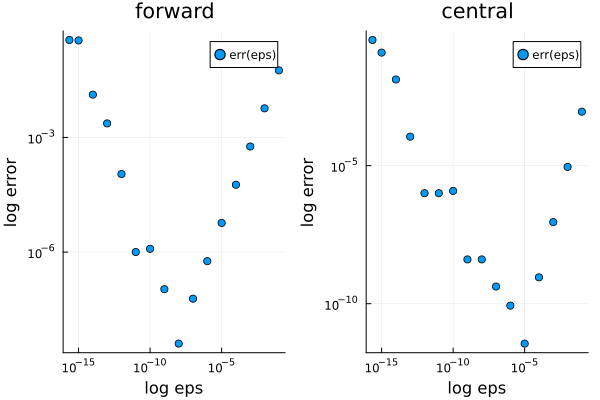

In [11]:
import Plots
using LinearAlgebra
f(x) = x^2+sin(x)
df(x) = 2*x+cos(x) # analytical derivative of f to estimate the error

eps_length = 16
eps_range = 10 .^ -range(1, stop=16, length=eps_length)
eps_range[eps_length] = 2.3*10^-16 # set the last element to 2.3e-16
x = 1.0
real_dfx = df(x)
df_forw_eps, df_cent_eps = FiniteDifferenceMethod(x, eps_range, f)
error_forward = abs.(df_forw_eps.-real_dfx)
error_central = abs.(df_cent_eps.-real_dfx)

p1 = Plots.scatter(eps_range, error_forward, label="err(eps)" , title="forward", xlabel="log eps", ylabel="log error", xscale=:log10, yscale=:log10)
p2= Plots.scatter(eps_range, error_central, label="err(eps)" , title="central", xlabel="log eps", ylabel="log error", xscale=:log10, yscale=:log10)
Plots.plot(p1, p2)

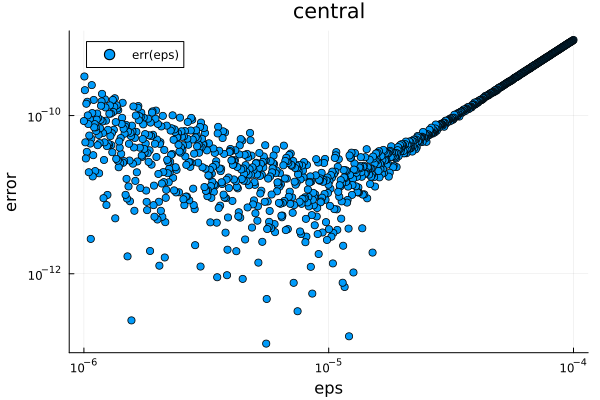

In [12]:
eps_range = 10 .^ -range(4, stop=6, length=1000)
df_fd_eps, df_cd_eps = FiniteDifferenceMethod(x, eps_range, f)

error = abs.(df_cd_eps.-real_dfx)

p3 = Plots.scatter(eps_range, error, label="err(eps)", title="central", xlabel="eps", ylabel="error", xscale=:log10, yscale=:log10)

# Derivatives of a function with multiple variables with finite differences
We have learned that the partial derivative of a function $f(x,y)$ with respect to $x$ is estimated by keeping $y$ constant and vice versa. We can use this approach to estimate the partial derivative using finite differences. Since the gradient of a function $f(x,y)$ is defined as:
$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}
\end{bmatrix}
$$
We can estimate the gradient with the partial derivative for each variable seperately.

Let's try this for the function $f(x, y) = x^2 + x*y$.

In [13]:
f(x,y)=x^2+x*y
a, b = 1.0, 1.0 # We want to estimate the partial derivatives of f at (a,b)

f_x(x) = f(x, b)
f_y(y) = f(a, y)

real_df_dx = 2*a+b
real_df_dy = a

df_dx_f_c = FiniteDifferenceMethod(a, [10^-8], f_x)
df_dy_f_c = FiniteDifferenceMethod(b, [10^-8], f_y)
df_dx = df_dx_f_c[2][1]
df_dy = df_dy_f_c[2][1]
@show grad_f = [df_dx, df_dy]
@show real_grad_f = [real_df_dx, real_df_dy];

grad_f = [df_dx, df_dy] = [2.9999999928698173, 0.999999993922529]
real_grad_f = [real_df_dx, real_df_dy] = [3.0, 1.0]


If we have another equation $g(x,y) = x^2 + y^2$ we can calculate the total derivative of the system of equations $f(x,y)$ and $g(x,y)$ with respect to $x$ and $y$ which is the Jacobian matrix:
$$
\mathbf{J} = \begin{bmatrix}
\nabla f \\
 \nabla g
\end{bmatrix} = \begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} \\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y}
\end{bmatrix} 
$$

In [14]:
g(x,y) = x^2 + y^2

g_x(x) = g(x, b)
g_y(y) = g(a, y)

real_dg_dx = 2*a
real_dg_dy = 2*b

dg_dx_f_c = FiniteDifferenceMethod(a, [10^-8], g_x)
dg_dy_f_c = FiniteDifferenceMethod(b, [10^-8], g_y)
dg_dx = dg_dx_f_c[2][1]
dg_dy = dg_dy_f_c[2][1]
@show grad_g = [dg_dx, dg_dy]
@show real_grad_g = [real_dg_dx, real_dg_dy]
@show jacobian_f = [df_dx df_dy; dg_dx dg_dy];

grad_g = [dg_dx, dg_dy] = [1.999999987845058, 1.999999987845058]
real_grad_g = [real_dg_dx, real_dg_dy] = [2.0, 2.0]
jacobian_f = [df_dx df_dy; dg_dx dg_dy] = [2.9999999928698173 0.999999993922529; 1.999999987845058 1.999999987845058]


We used an inefficient way to calculate the Jacobian. We needed to calculate the partial derivative of each function with respect to each variable. There are more efficient ways to calculate the Jacobian matrix like using colored Jacobians or automatic differentiation (next section).

In practice you can use FiniteDifferences.jl to calculate the Jacobian matrix using finite differences. This package can be installed with `Pkg.add("FiniteDifferences")`. 
Let's try this out for the function 
$$
\mathbf{f(x)} =  \begin{bmatrix}
x_1^2 + x_1*x_2 \\
x_1^2 + x_2^2
\end{bmatrix} 
$$. 
We can use the function `jacobian` from the package FiniteDifferences.jl to calculate the Jacobian matrix:

In [15]:
import FiniteDifferences
f(x) = [x[1]^2+x[1]*x[2]; 
        x[1]^2+x[2]^2]
x = [1.0, 1.0]

FiniteDifferences.jacobian(FiniteDifferences.central_fdm(2, 1), f, x)[1]

2×2 Matrix{Float64}:
 3.0  1.0
 2.0  2.0

We can see that the central difference approximation is of order O(eps^2). It increases quadratically with eps and is smaller than the forward difference approximation

# Calculation the end effector velocity based on the joint velocities

We can measure the joint velocities of our Openmanipulator. However, we are interested in the speed of the end effector. We have seen in the lecture that we can calculate the end effector velocity based on the joint velocities using the Jacobian matrix. 

## Estimating the Jacobian matrix of the Openmanipulator-X kinematics
To estimate the velocity of the end effector we need to know the forward kinematics of the Openmanipulator-X and estimate the derivative of the forward kinematics. 



In [16]:
using Revise
include("../OpenManipulatorLib/OpenManipulatorKinematics.jl")
using .OpenManipulatorKinematics

Estimate the jacobian matrix of the forward kinematics for our robot arm using finite differences. We can use the function `FiniteDifferences.jacobian` to calculate the Jacobian matrix of the forward kinematics. 

In [17]:
import FiniteDifferences

function openmanipulator_jacobian(q)
    # Define a function that returns the position of the end effector
    f(q) = OpenManipulatorKinematics.complete_forward_kinematics(q)[1]
    
    J = FiniteDifferences.jacobian(FiniteDifferences.central_fdm(2, 1), f, q)[1]

    return J
end

openmanipulator_jacobian (generic function with 1 method)

Now, test the methods. What do you observe?

In [18]:
q = [0.1, 0.0, 0.0, 0.1]

4-element Vector{Float64}:
 0.1
 0.0
 0.0
 0.1

In [19]:
@time openmanipulator_jacobian(q)

  0.833360 seconds (4.05 M allocations: 276.326 MiB, 5.84% gc time, 99.85% compilation time: 2% of which was recompilation)


3×4 Matrix{Float64}:
 -0.0437861   0.119245   -0.00811564  -0.00811564
  0.22605     0.0119644  -0.00081428  -0.00081428
  0.0        -0.229292   -0.205292    -0.0812918

## Calculating the end effector velocity using the Jacobian matrix

In the lecture you learned that based on the total derivative we can derive the rule for differentiating our system of equations $f_1(x,y)$ and $f_2(x,y)$ with respect to the variable $t$ when $x$ and $y$ are functions of $t$:
$$
\frac{d}{dt} \begin{bmatrix}
f_1(x,y) \\
f_2(x,y)
\end{bmatrix} = \begin{bmatrix}
\frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} \\
\frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y}
\end{bmatrix} \begin{bmatrix}
\frac{\partial x}{\partial t} \\
\frac{\partial y}{\partial t}
\end{bmatrix}
= \mathbf{J} \begin{bmatrix}
\frac{\partial x}{\partial t} \\
\frac{\partial y}{\partial t}
\end{bmatrix}
$$

Based on this rule we can estimate the end effector velocity using the Jacobian matrix. We can use the following estimation:
$$
v = \mathbf{J}(q) * \mathbf{q}_v = \mathbf{J}(q) * \begin{bmatrix}
\frac{\partial q_1}{\partial t} \\
\frac{\partial  q_2}{\partial t} \\
\frac{\partial  q_3}{\partial t} \\
\frac{\partial  q_4}{\partial t} \\
\end{bmatrix} 
\approx J(q) * \begin{bmatrix}
\Delta q_1 \\
\Delta q_2 \\
\Delta q_3 \\
\Delta q_4 \\
\end{bmatrix} 
$$

where $v$ is the end effector velocity, $\mathbf{J}(q)$ is the Jacobian matrix evaluated at the current joint angles $q$, and $\mathbf{q}_v$ is the joint velocity vector, which we can estimate with the joint approximate velocities $\Delta q_1$, $\Delta q_2$, $\Delta q_3$, and $\Delta q_4$.

Implement the `endeffector_velocity` function that uses the Jacobian matrix to calculate the end effector velocity. The function should take the joint angles `q` and joint velocity vector `q_v`, and returns the end effector velocity `v` calculated using the Jacobian matrix. Use the `openmanipulator_jacobian` function you implemented to calculate the Jacobian matrix.

In [20]:
function endeffector_velocity(q, q_v)
    # Calculate the Jacobian matrix at the current joint angles
    J = openmanipulator_jacobian(q)

    # Calculate the end effector velocity using the Jacobian matrix
    v = J * q_v

    return v
end

endeffector_velocity (generic function with 1 method)

Let's test the function with the following joint angles and joint velocities:

In [21]:
q_v = [0.0, 0.0, 0.0, 0.0]
v = endeffector_velocity(q, q_v)

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [22]:
q_v = [0.0, 0.5, 0.0, 0.0]
v = endeffector_velocity(q, q_v)

3-element Vector{Float64}:
  0.05962244508784914
  0.0059821984331641185
 -0.11464591943774666

Let's load the Openmanipulator-X model and calculate the Jacobian matrix using the `openmanipulator_jacobian` function. We can use the `endeffector_velocity` function to calculate the end effector velocity based on the joint velocities.

In [23]:
using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using LinearAlgebra
using StaticArrays

┌ Warning: attempting to remove probably stale pidfile
│   path = /Users/damian/.jlassetregistry.lock
└ @ Pidfile /Users/damian/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


In [29]:
srcdir = "../open_manipulator_description/urdf/"
urdf = joinpath(srcdir, "open_manipulator.urdf")
mechanism = parse_urdf(urdf)

Spanning tree:
Vertex: world (root)
  Vertex: link2, Edge: joint1
    Vertex: link3, Edge: joint2
      Vertex: link4, Edge: joint3
        Vertex: link5, Edge: joint4
          Vertex: gripper_link, Edge: gripper
          Vertex: gripper_link_sub, Edge: gripper_sub
No non-tree joints.

In [30]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
render(mvis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8705
└ @ MeshCat /Users/damian/.julia/packages/MeshCat/oC0sL/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("link1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "link2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_joint1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x65, 0x72, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "link3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x32, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_joint2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x65, 0x72, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "link4" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x33, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_joint3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x65, 0x72, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "link5" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0

In [31]:
final_time = 3.0
ts, qs, vs = simulate(mvis.state, final_time);

In [34]:
set_configuration!(mvis, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
zero_velocity!(state)

In [35]:
state = mvis.state
@show joint_state = mvis.state.q
@show velocity = mvis.state.v;

joint_state = mvis.state.q = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
velocity = mvis.state.v = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Let's take the controller method we introduced in exercise 3 (the introduction of the Openmanipulator-X). 

We can use the `endeffector_velocity` function to calculate the end effector velocity based on the joint velocities. We can use this information to extend the control method of the robot arm.

In [36]:
om_joints = joints(mechanism)
function joint_position_control(q_state, v_state, q_desired)
    kp = 2.0
    v_damping = 0.5
    max_torque = 1.0

    torque = kp * (q_desired - q_state) - v_damping * v_state
    torque = clamp.(torque, -max_torque, max_torque)

    return torque
end;

In [37]:
function simple_joint_control!(torques::AbstractVector, t, state::MechanismState)
    joint_number = 1
    position = 0.5

    for j_iter in 1:6
        if j_iter != joint_number
            state.v[j_iter] = 0.0
        end
    end
    for joint in om_joints
        torques[velocity_range(state, joint)] .= 0.0
    end
    torques[velocity_range(state, om_joints[joint_number])] .= joint_position_control(state.q[joint_number], state.v[joint_number], position)
    v = endeffector_velocity(state.q[1:4], q_v[1:4])
    println("End effector velocity: ", v)
end;

In [38]:
final_time = 2.0
ts, qs, vs = simulate(mvis.state, final_time, simple_joint_control!; Δt=1e-2);
MeshCatMechanisms.animate(mvis, ts, qs)

End effector velocity: [0.06400000008831189, 0.0, -0.11484999935362422]
End effector velocity: [0.06400000008831189, 0.0, -0.11484999935362422]
End effector velocity: [0.06399982064436037, 0.00015151414020392944, -0.11484999875679198]
End effector velocity: [0.0639995822736549, 0.00023129258843176907, -0.11485000010325598]
End effector velocity: [0.06399947036362626, 0.00026038653358660815, -0.1148500001900806]
End effector velocity: [0.06399803941975452, 0.000500926508392345, -0.11484999924734497]
End effector velocity: [0.0639972409746858, 0.0005942612527416798, -0.11485000013549992]
End effector velocity: [0.06399392673191229, 0.0008816564015958992, -0.11484999937652361]
End effector velocity: [0.06399366414943677, 0.0009005159258407041, -0.11485000019182806]
End effector velocity: [0.06398705319508714, 0.001287230723138345, -0.1148500002820557]
End effector velocity: [0.06398590927928288, 0.0013429113079476663, -0.11484999952791111]
End effector velocity: [0.06397592637553053, 0.00